In [ ]:
#ライブラリインポート
import pandas as pd
!pip install japanize_matplotlib
import japanize_matplotlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.utils.validation import column_or_1d
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_rows', 150)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#データ読み込み
df = pd.read_csv(r'ver5_1.csv',
                 engine='python',
                 index_col='date'
                )
#columns=["日検査数","日陽性数","日患者数","日軽症中等症数","ラベル","平均気温(℃)","降水量の合計(mm)","日照時間(時間)","降雪量合計(cm)","平均風速(m/s)","平均湿度(％)","平均雲量(10分比)"]
#columns=["日陽性数","日検査数","平均気温(℃)","日照時間(時間)","平均湿度(％)","平均風速(m/s)","平均雲量(10分比)","日患者数"]
df.index=pd.to_datetime(df.index)

#targetに目的変数を設定
target="日陽性数"

print(df.columns)
#なんか必要ないカラムがあるので削除
df=df.drop("Unnamed: 0",axis=1)

#この辺は説明変数作るのに試行錯誤した後
df["南北線"]=df["大通（南北線）"]+df["さっぽろ（南北線）"]
df["年代合計"]=0
for age in ["10歳未満","10代","20代","30代","40代","50代","60代","70代","80代","90代"]:
  df["年代合計"]=df["年代合計"]+df[age]

Index(['Unnamed: 0', '10歳未満', '10代', '20代', '30代', '40代', '50代', '60代', '70代',
       '80代',
       ...
       'AMZN株価-始値', 'AMZN株価-高値', 'AMZN株価-安値', 'AMZN株価-出来高', 'AMZN株価-変化率 %',
       '日経株価-終値', '日経株価-始値', '日経株価-高値', '日経株価-安値', '休日ラベル'],
      dtype='object', length=117)


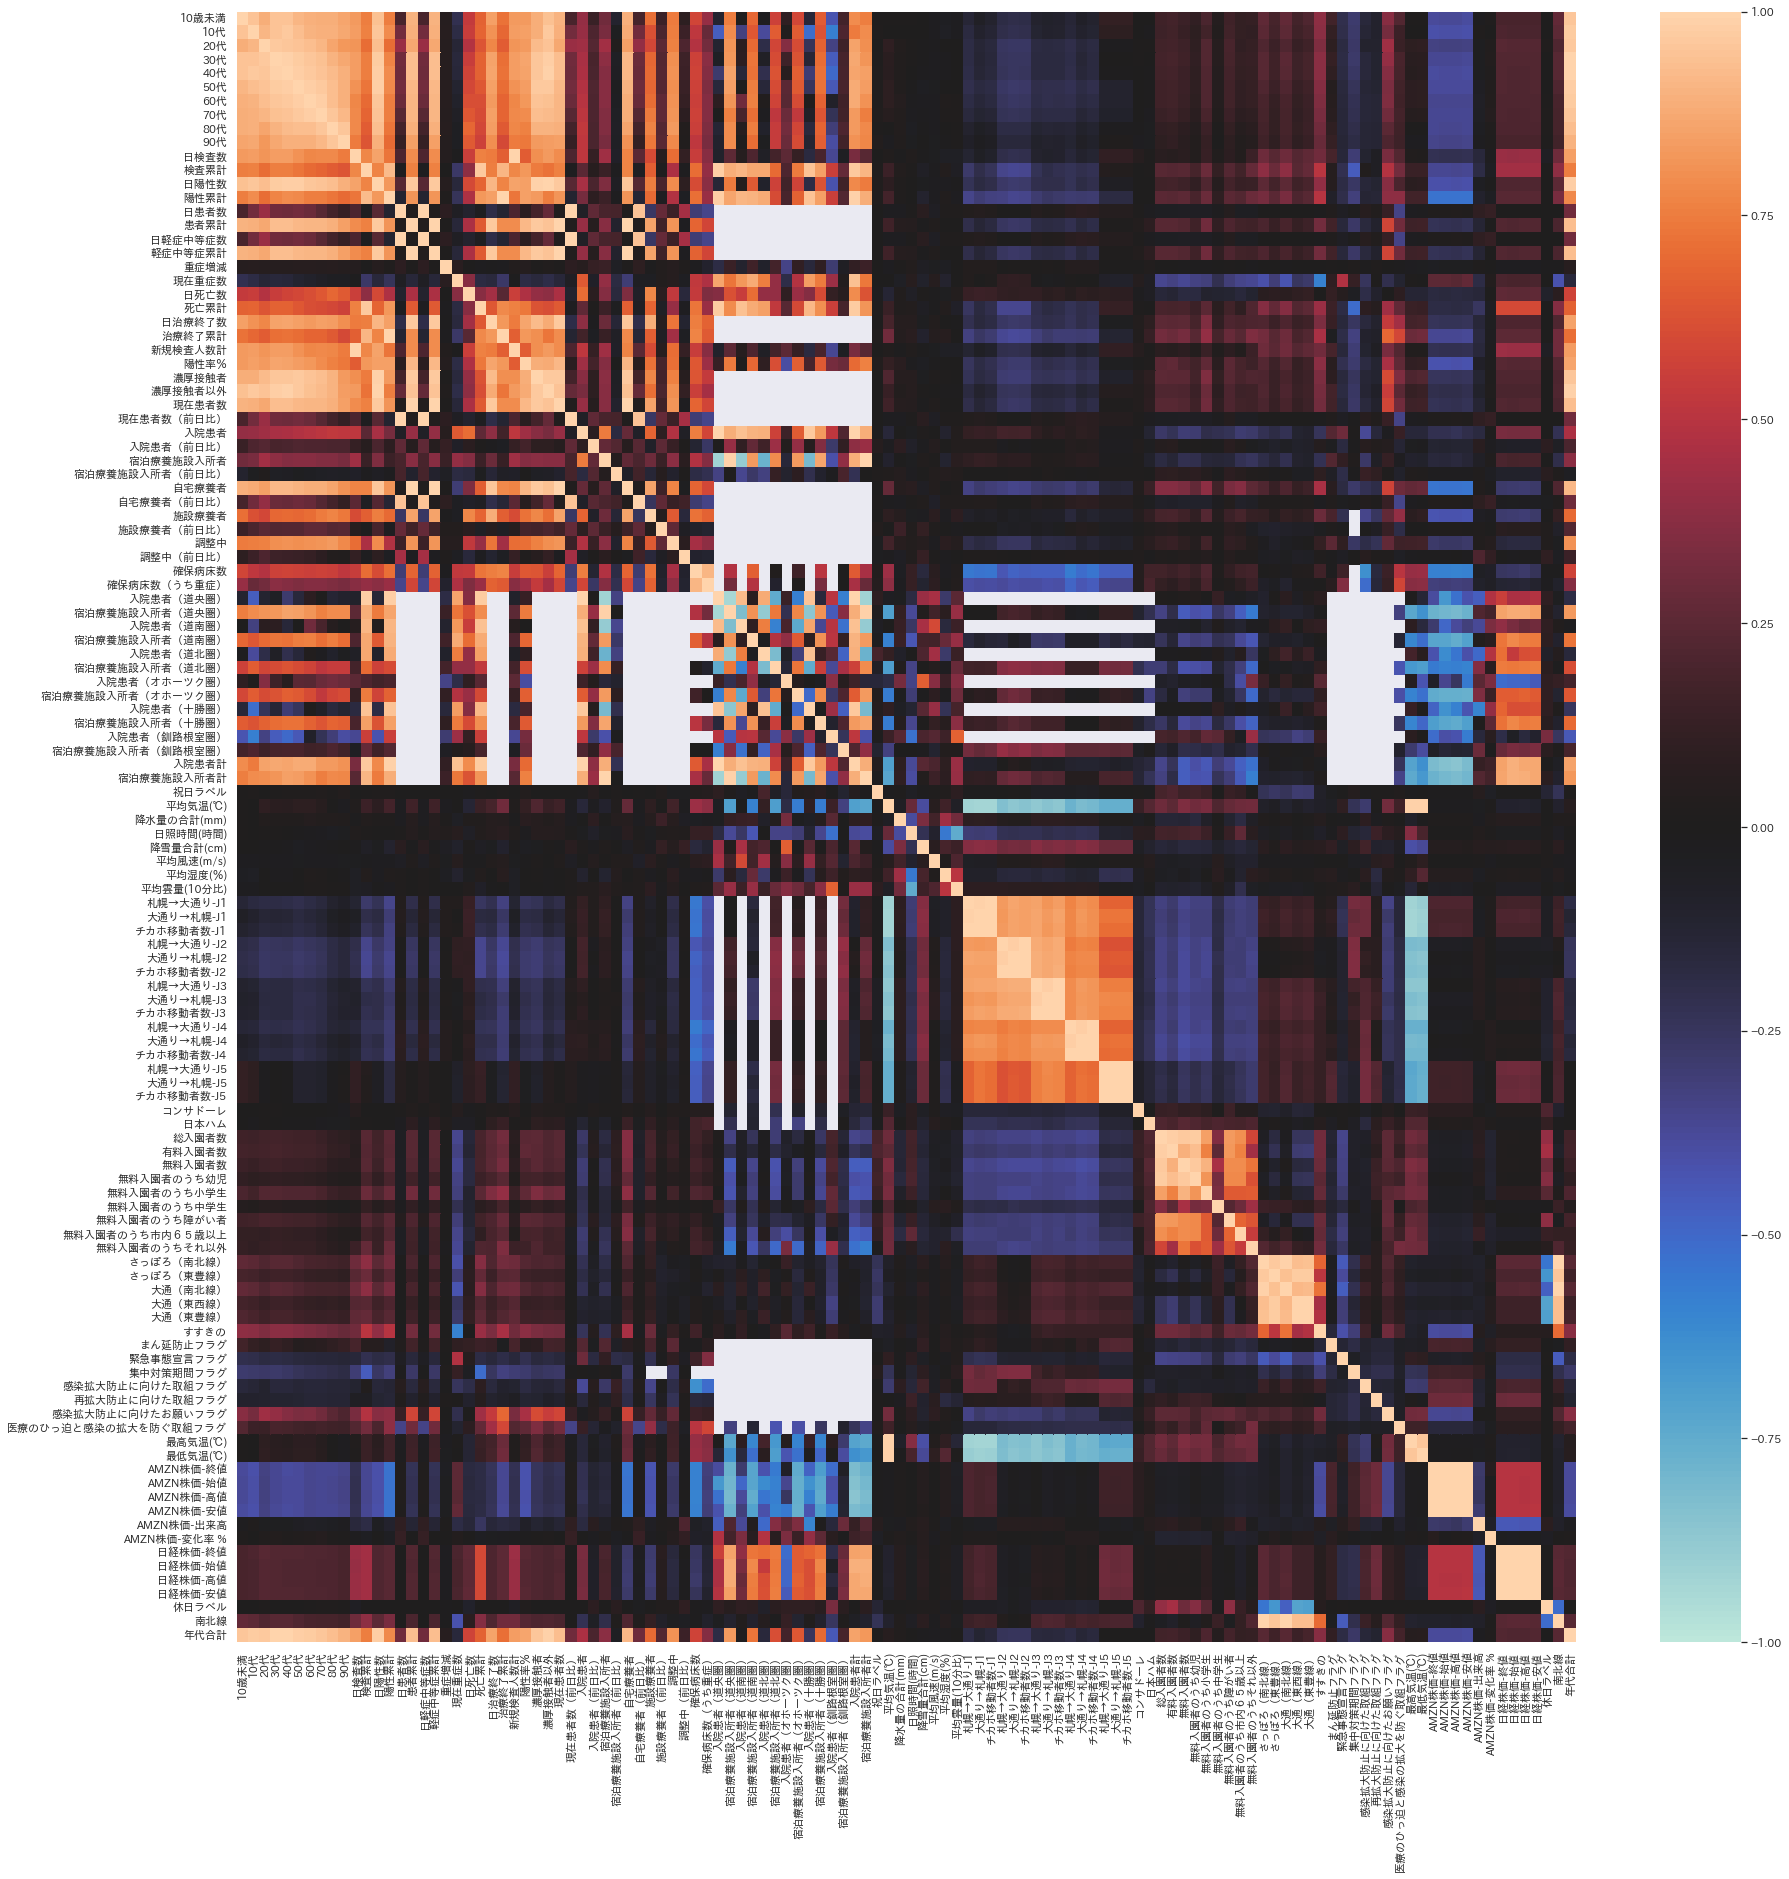

In [ ]:
#データ全体のヒートマップを出力
#データが多すぎると少し見にくい
df_corr =df.corr()
sns.set(rc = {'figure.figsize':(30,30)},font="IPAexGothic")
sns.heatmap(df_corr, vmax=1, vmin=-1, center=0)

In [ ]:
#陽性者との相関係数一覧
print(df_corr["日陽性数"].sort_values(ascending=False))

日陽性数                    1.000000
濃厚接触者以外                 0.992384
濃厚接触者                   0.987999
年代合計                    0.984343
40代                     0.983333
50代                     0.979106
30代                     0.970535
軽症中等症累計                 0.965463
現在患者数                   0.965430
患者累計                    0.965430
60代                     0.960709
10代                     0.960090
自宅療養者                   0.959417
70代                     0.951878
10歳未満                   0.938228
20代                     0.935647
80代                     0.934800
日治療終了数                  0.907607
90代                     0.897434
日検査数                    0.854258
新規検査人数計                 0.853920
陽性率％                    0.844422
陽性累計                    0.822756
調整中                     0.794031
入院患者計                   0.783049
検査累計                    0.771001
治療終了累計                  0.768244
施設療養者                   0.751640
宿泊療養施設入所者（道央圏）          0.749524
宿泊療養施設入所者計              0.743323
死亡累計      

In [ ]:
#学習に使うデータ定義(目的変数込み)
columns=["日陽性数","日検査数","日患者数","日死亡数","最低気温(℃)","最高気温(℃)","感染拡大防止に向けたお願いフラグ","すすきの","年代合計","陽性率％","入院患者","南北線"]
"""
columns=["日検査数","日陽性数",
         "日患者数",
         #"日軽症中等症数",
         "現在重症数","日死亡数","死亡累計",
         #"濃厚接触者","現在患者数",
         "祝日ラベル","休日ラベル",
         #"平均気温(℃)",
         "降水量の合計(mm)","日照時間(時間)","降雪量合計(cm)","平均湿度(％)","平均雲量(10分比)","コンサドーレ","日本ハム","総入園者数",
         #"有料入園者数","無料入園者数","無料入園者のうち幼児","無料入園者のうち小学生","無料入園者のうち中学生","無料入園者のうち障がい者","無料入園者のうち市内６５歳以上","無料入園者のうちそれ以外",
         #"さっぽろ（南北線）","さっぽろ（東豊線）",
         #"大通（南北線）",
         "すすきの","まん延防止フラグ","緊急事態宣言フラグ","集中対策期間フラグ","感染拡大防止に向けた取組フラグ","再拡大防止に向けた取組フラグ","感染拡大防止に向けたお願いフラグ","医療のひっ迫と感染の拡大を防ぐ取組フラグ","最高気温(℃)",
         "最低気温(℃)",
         "日経株価-高値","AMZN株価-高値"
         #,"AMZN株価-出来高"
         ,"曜日"
         ]
"""

#データ作成
df=df[columns]
df["気温加工データ"]=df["最高気温(℃)"]*df["最低気温(℃)"]
df=df.drop("最高気温(℃)",axis=1)
df=df.drop("最低気温(℃)",axis=1)
print(df.isnull().sum())
df=df.dropna()


#二日のラグを作る
df['日付ラグ']=df["日陽性数"].shift(3)
#曜日取得
#df["曜日"]=df.index.weekday

日陽性数                  0
日検査数                  0
日患者数                 65
日死亡数                  0
感染拡大防止に向けたお願いフラグ      0
すすきの                  0
年代合計                  1
陽性率％                  0
入院患者                138
南北線                   0
気温加工データ               0
dtype: int64


<ipython-input-73-aa5370251fec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["気温加工データ"]=df["最高気温(℃)"]*df["最低気温(℃)"]


In [ ]:
#df['階差']=df['日陽性数'].diff()
#ラグ項追加

#ローリング特徴量追加
#df['r_week_sum']=df['日陽性数'].rolling(7).sum()
#df['r_week_std']=df['日陽性数'].rolling(7).std()
#df['r_week_mean']=df['日陽性数'].rolling(7).mean()
#df['r_week_max']=df['日陽性数'].rolling(7).max()
#df['r_week_min']=df['日陽性数'].rolling(7).min()
#df['max-min']=df['r_week_max']-df['r_week_min']

#エクスパディング特徴量追加
#df['e_sum']=df['日陽性数'].expanding().sum()
#df['e_std']=df['日陽性数'].expanding().std()
#df['e_mean']=df['日陽性数'].expanding().mean()



df=df.dropna()
df

,日陽性数,日検査数,日患者数,日死亡数,感染拡大防止に向けたお願いフラグ,すすきの,年代合計,陽性率％,入院患者,南北線,気温加工データ,日付ラグ
date,,,,,,,,,,,,
2020-07-04,1.0,272.0,-7.0,0.0,0.0,9698.0,0.0,0.4,77.0,58243.0,366.30,4.0
2020-07-05,1.0,172.0,-4.0,0.0,0.0,7279.0,0.0,0.6,75.0,44572.0,420.75,8.0
2020-07-06,0.0,143.0,-5.0,0.0,0.0,8332.0,0.0,0.0,71.0,70709.0,494.78,0.0
2020-07-07,1.0,86.0,-7.0,0.0,0.0,8736.0,0.0,1.2,65.0,73407.0,491.40,1.0
2020-07-08,4.0,186.0,-10.0,0.0,0.0,8731.0,2.0,2.2,58.0,71344.0,501.76,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-22,3341.0,14349.0,-101.0,12.0,0.0,12355.0,1334.0,23.4,550.0,90642.0,187.48,1663.0
2022-09-23,3164.0,11122.0,588.0,4.0,0.0,12254.0,1297.0,28.5,559.0,71077.0,343.07,1364.0
2022-09-24,2207.0,3200.0,-221.0,2.0,0.0,13803.0,969.0,69.1,550.0,73866.0,359.64,2040.0


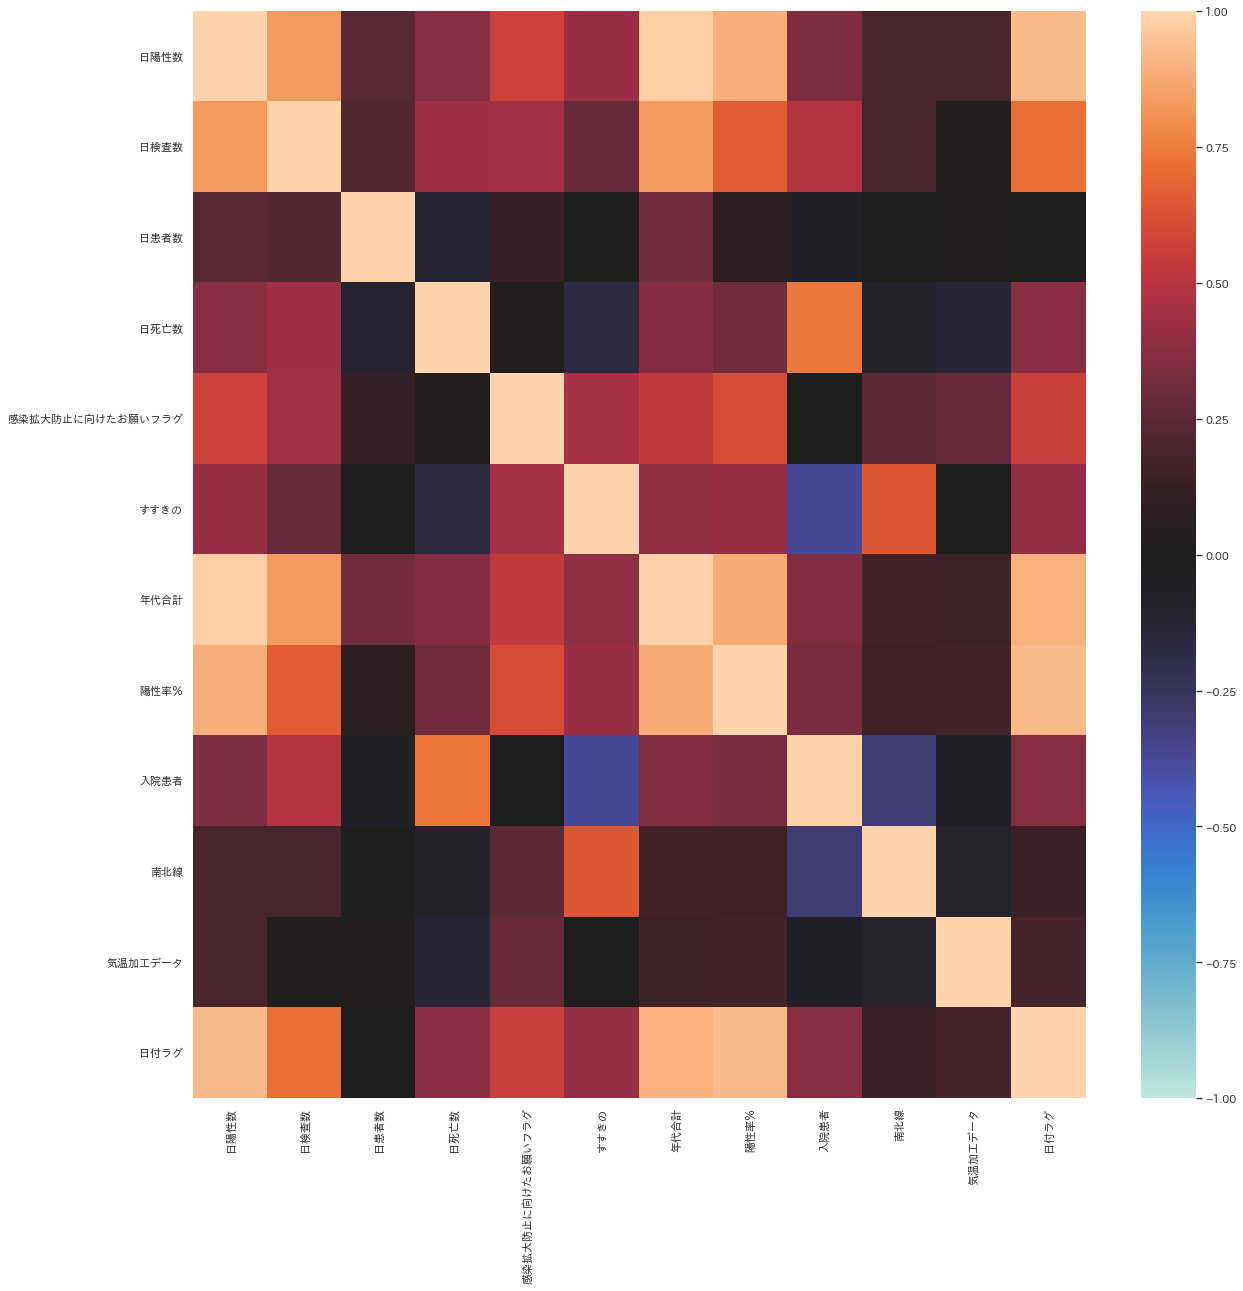

In [ ]:
#説明変数選定後のヒートマップ作成
df_corr =df.corr()
sns.set(rc = {'figure.figsize':(20,20)},font="IPAexGothic")
sns.heatmap(df_corr, vmax=1, vmin=-1, center=0)

In [ ]:
#データの標準化
scaler=MinMaxScaler(feature_range=(0,1))
df_scale=pd.DataFrame(scaler.fit_transform(df),index=df.index,columns=df.columns)

In [ ]:
#訓練データとテストデータに分ける。訓練:~2022-07-31,テスト:2022-08-01~2022-08-31
train=df_scale[:'2022-07-31']
test=df_scale['2022-08-01':'2022-08-31']

In [ ]:
df_scale

,日陽性数,日検査数,日患者数,日死亡数,感染拡大防止に向けたお願いフラグ,すすきの,年代合計,陽性率％,入院患者,南北線,気温加工データ,日付ラグ
date,,,,,,,,,,,,
2020-07-04,0.000116,0.012870,0.493066,0.000000,0.0,0.518493,0.000000,0.004306,0.057325,0.431929,0.449621,0.000463
2020-07-05,0.000116,0.005951,0.493424,0.000000,0.0,0.329744,0.000000,0.006459,0.055505,0.296511,0.507341,0.000927
2020-07-06,0.000000,0.003944,0.493305,0.000000,0.0,0.411907,0.000000,0.000000,0.051865,0.555411,0.585817,0.000000
2020-07-07,0.000116,0.000000,0.493066,0.000000,0.0,0.443430,0.000000,0.012917,0.046406,0.582136,0.582234,0.000116
2020-07-08,0.000463,0.006919,0.492707,0.000000,0.0,0.443040,0.000532,0.023681,0.040036,0.561701,0.593216,0.000116
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-22,0.387048,0.986922,0.481827,0.631579,0.0,0.725811,0.355071,0.251884,0.487716,0.752858,0.260063,0.192655
2022-09-23,0.366543,0.763631,0.564204,0.210526,0.0,0.717931,0.345222,0.306781,0.495905,0.559057,0.424996,0.158017
2022-09-24,0.255677,0.215472,0.467480,0.105263,0.0,0.838795,0.257919,0.743811,0.487716,0.586683,0.442561,0.236330


In [ ]:
look_back=20#振り返る日数

#LSTMに適する形へ加工
def create_input_data(data,look_back):
  raw_data=data.T.values.tolist()
  data_size=len(data) - look_back
  print(data_size)
  X=[[] for i in range(len(raw_data))]
  Y=[[] for i in range(len(raw_data))]

  for i in range(data_size):
    for j in range(len(raw_data)):
      X[j].append(raw_data[j][ i : i + look_back])
      Y[j].append([raw_data[j][i + look_back]])
  x_temp=X[-1]
  y_temp=Y[-1]
  for i in range(len(raw_data)-1):
    x_temp=np.insert(x_temp,np.arange(0,(look_back-1)*(i+1)+1,i+1),X[-i-2],axis=1)
    y_temp=np.insert(y_temp,np.arange(0,(i+1),i+1),Y[-i-2],axis=1)
  X=np.array(x_temp).reshape(data_size,look_back,len(raw_data))
  Y=np.array(y_temp).reshape(data_size,1,len(raw_data))
  return Y, X

y_train,x_train=create_input_data(train,look_back)
y_test,x_test=create_input_data(test,look_back)

#各データ確認
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

737
11
(737, 20, 12)
(737, 1, 12)
(11, 20, 12)
(11, 1, 12)


In [ ]:
#モデル定義
#この辺をいじくり回して精度向上を目指す
model=Sequential()
x=model.add(LSTM(30,input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(len(df.columns)))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
#エポック数50,バッチサイズ1で学習
#エポック数、バッチサイズの数でも精度は変化する

history=model.fit(x_train,y_train,epochs=50,batch_size=1)

Epoch 1/50
737/737 [==============================] - 6s 5ms/step - loss: 0.0153
Epoch 2/50
737/737 [==============================] - 3s 3ms/step - loss: 0.0063
Epoch 3/50
737/737 [==============================] - 3s 4ms/step - loss: 0.0055
Epoch 4/50
737/737 [==============================] - 2s 3ms/step - loss: 0.0051
Epoch 5/50
737/737 [==============================] - 4s 5ms/step - loss: 0.0046
Epoch 6/50
737/737 [==============================] - 4s 6ms/step - loss: 0.0043
Epoch 7/50
737/737 [==============================] - 4s 6ms/step - loss: 0.0040
Epoch 8/50
737/737 [==============================] - 4s 6ms/step - loss: 0.0040
Epoch 9/50
737/737 [==============================] - 4s 5ms/step - loss: 0.0038
Epoch 10/50
737/737 [==============================] - 3s 3ms/step - loss: 0.0037
Epoch 11/50
737/737 [==============================] - 3s 3ms/step - loss: 0.0037
Epoch 12/50
737/737 [==============================] - 3s 3ms/step - loss: 0.0036
Epoch 13/50
737/737 [====

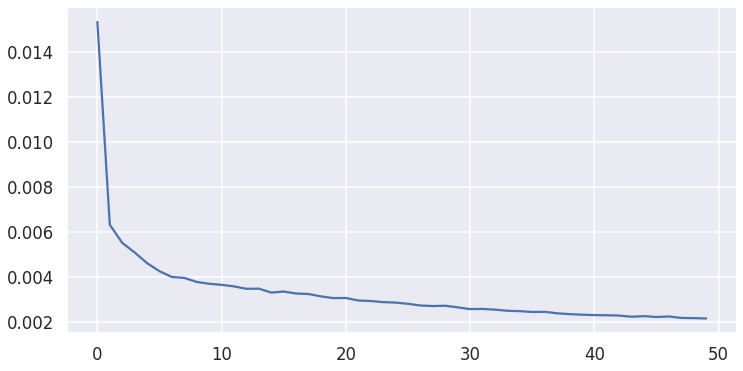

In [ ]:
#誤差推移
sns.set(context="talk")
fig=plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])

24/24 [==============================] - 0s 2ms/step
(737, 12)
1/1 [==============================] - 0s 28ms/step


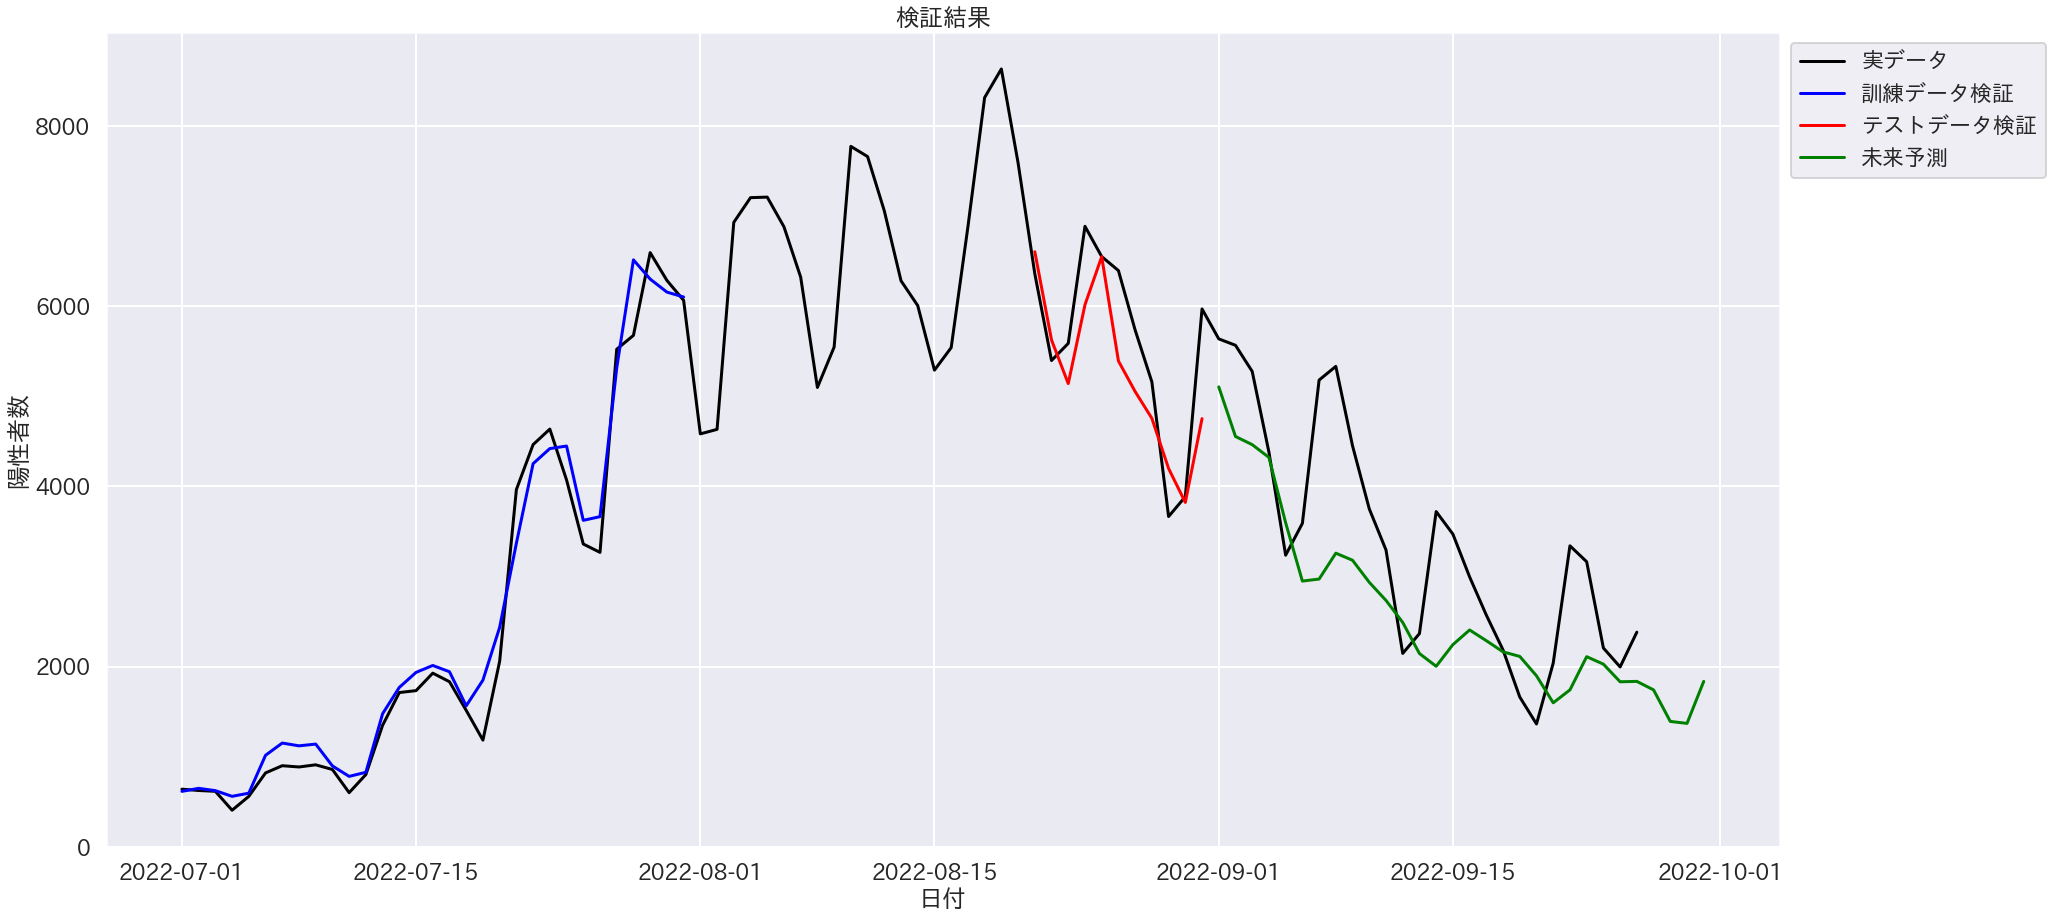

In [ ]:
#グラフ設定
sns.set(context="poster",font="IPAexGothic")
fig=plt.subplots(figsize=(30,15))
plt.title("検証結果")
plt.xlabel("日付")
plt.ylabel("陽性者数")

#実データプロット
df=pd.DataFrame(scaler.inverse_transform(df_scale),index=df.index,columns=df.columns)
plt.plot(df['2022-07-01':]["日陽性数"],color="black",label="実データ")
plt.legend("実データ")
print(model.predict(x_train).shape)

#訓練データ検証プロット
df_train_pred=pd.DataFrame(scaler.inverse_transform(model.predict(x_train)),index=train.index[look_back:],columns=df.columns)
plt.plot(df_train_pred['2022-07-01':'2022-07-31']["日陽性数"],color="blue",label="訓練データ検証")
plt.legend("訓練データ検証")

#テストデータ検証プロット
df_test_pred=pd.DataFrame(scaler.inverse_transform(model.predict(x_test)),index=test.index[look_back:],columns=df.columns)
plt.plot(df_test_pred["日陽性数"],color="red",label="テストデータ検証")
plt.legend("テストデータ検証")

#未来予測
future_steps=30
x_future=[test[-look_back:].values.tolist()]
y_future_list=[]
for step in range(future_steps):
  y_future=model.predict(x_future)
  y_future_list.append(y_future[0])
  x_future=[x_future[0][1:]+y_future.tolist()]

#予測値プロット
df_future=pd.DataFrame(scaler.inverse_transform(y_future_list),index=pd.date_range('2022-09-01',periods=future_steps),columns=df.columns)
plt.plot(df_future['日陽性数'],color="green",label="未来予測")
plt.legend("未来予測")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

In [ ]:
#MAPE計算
import datetime as dt
day='2022-08-01'
day=pd.to_datetime(day)
predict_start=day + dt.timedelta(days=look_back)
predict_end=predict_start + dt.timedelta(days=len(df_test_pred)-1)
print(predict_start)
print(predict_end)
df_test_check=df[predict_start:predict_end]['日陽性数']
MAPE=np.mean(np.abs(( df_test_check.values- df_test_pred['日陽性数'].values) /  df_test_check.values)) * 100
print(f"MAPE:{MAPE}")

2022-08-21 00:00:00
2022-08-31 00:00:00
MAPE:9.151365948440203


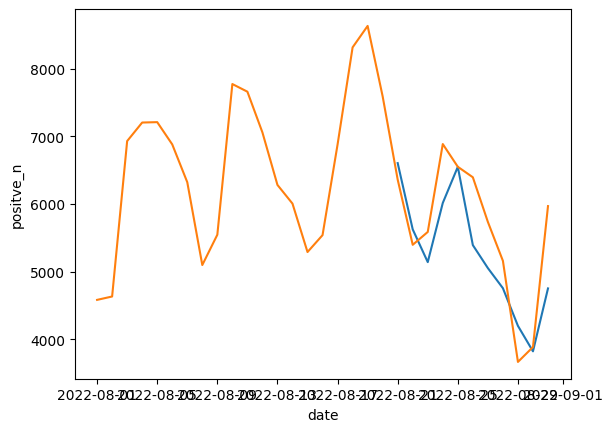

In [ ]:
plt.clf()
import matplotlib
import japanize_matplotlib
matplotlib.style.use('default')
plt.plot(df_test_pred["日陽性数"])
plt.plot(df['2022-08-01':'2022-08-31']["日陽性数"])
plt.xlabel("date")
plt.ylabel("positve_n")
plt.show()